In [1]:
import gymnasium as gym 
from gymnasium import Env
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import tensorflow as tf
import datetime
import gymnasium as gym
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
import tensorflow as tf

# # Set seed for reproducibility
# seed = 42
# random.seed(seed)
# np.random.seed(seed)

class missile_interception(Env):
    def __init__(self):
        self.action_space = gym.spaces.discrete.Discrete(3)
        """STATE INCLUDES:
        - attack_x: x-coordinate of the attack point (Low: -1, High: 1)
        - attack_y: y-coordinate of the attack point (Low: -1, High: 1)
        - defense_x: x-coordinate of the defense point (Low: -1, High: 1)
        - defense_y: y-coordinate of the defense point (Low: -1, High: 1)
        - target_x: x-coordinate of the target point (Low: -1, High: 1)
        - target_y: y-coordinate of the target point (Low: -1, High: 1)
        - attack_missile_theta: angle between the defense and the attack point (low: 0, high: 2*pi)
        - attack_target_theta: angle between the attack and the target point (low: 0, high: 2*pi)
        - missile_angle: angle of the missile (low: 0, high: 2*pi)
        - difference in of attack_missile_theta and missile_angle (low: 0, high: pi)
        - distance_attack_missile: distance between the defense and attack point (low: 0, high: 2.9)
        - distance_attack_target: distance between the attack and target point (low: 0, high: 2.9)
        - attack_missile_theta in sin form (low: -1, high: 1)
        - attack_missile_theta in cos form (low: -1, high: 1)
        - missile_angle in sin form (low: -1, high: 1)
        - missile_angle in cos form (low: -1, high: 1)
        - delta_sin: difference in sin form between attack_missile_theta and missile_angle (low: -2, high: 2)
        - delta_cos: difference in cos form between attack_missile_theta and missile_angle (low: -2, high: 2)
        """
        low = np.array([-1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -2, -2])
        high = np.array([1, 1, 1, 1, 1, 1, 2*math.pi, 2*math.pi, 2*math.pi, math.pi, 2.9, 2.9, 1, 1, 1, 1, 2, 2])
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)
        self.radius = 0.02

        self.episode_count = 0
        self.distance_t_minus_one = 0
        self.distance_change = 0

        self.out_of_bounds = 0
        self.interceptions = 0
        self.reached_max_steps = 0

        self.defense_positions = []
        self.attack_positions = []

        self.max_steps_per_episode = 150

    def reset(self, seed=None):
        self.defense_positions = []
        self.attack_positions = []
        self.reward = 0
        self.current_step = 0
        self.done = False
        self.create_target()
        self.create_defense(self.target)
        self.create_attack(self.target)

        self.calc_attack_missile_theta(self.defense, self.attack)
        self.initial_missile_angle()
        self.missile_distance_to_attack()
        self.attack_distance_to_target()

        self.graph(self.defense, self.attack, self.target)
        self.get_state()

        return self.state, {}

    def create_target(self):
        x = random.uniform(-0.3, 0.3)
        y = random.uniform(-0.3, 0.3)
        self.target = np.array([x, y])

    def create_defense(self, target):
        x = random.uniform((target[0] - self.radius) - 0.15, (target[0] + self.radius) + 0.15)
        y = random.uniform((target[1] - self.radius) - 0.15, (target[1] + self.radius) + 0.15)
        self.defense = np.array([x, y])

    def create_attack(self, target):
        x_side_left = random.uniform(-0.95, (target[0] - self.radius) - 0.2)
        x_side_right = random.uniform((target[0] + self.radius) + 0.2, 0.95)
        y_below = random.uniform((target[1] - self.radius) - 0.2, -0.95)
        y_above = random.uniform((target[1] + self.radius) + 0.2, 0.95)
        x_inclusive = random.uniform(-0.95, 0.95)
        y_inclusive = random.uniform(-0.95, 0.95)
        y_below_x_inclusive = np.array([x_inclusive, y_below])
        y_above_x_inclusive = np.array([x_inclusive, y_above])
        x_left_y_inclusive = np.array([x_side_left, y_inclusive])
        x_right_y_inclusive = np.array([x_side_right, y_inclusive])

        self.attack = random.choice([y_below_x_inclusive, y_above_x_inclusive, x_left_y_inclusive, x_right_y_inclusive])

    def calc_attack_missile_theta(self, defense, attack):

        # create an adjacent point of the form (attack_x, defense_y)
        adjacent_point = np.array([attack[0], defense[1]])

        # calculate the distance between the adjacent point and the defense, attack points
        adj_point_defense_len = abs(defense[0] - adjacent_point[0]) 
        adj_point_attack_len = abs(attack[1] - adjacent_point[1])

        # calculate the angle, using soh cah toa, where adj_point_defense_len is the adjacent side and adj_point_attack_len is the opposite side
        self.attack_missile_theta = np.arctan(adj_point_attack_len / adj_point_defense_len)
        
        if attack[0] > defense[0]:
            if attack[1] > defense[1]:
                self.attack_missile_theta = self.attack_missile_theta # 1st quadrant
            else: 
                self.attack_missile_theta = (2*math.pi) - self.attack_missile_theta # 360 - theta
        else:
            if attack[1] > defense[1]:
                self.attack_missile_theta = math.pi - self.attack_missile_theta # 180 - theta
            else:
                self.attack_missile_theta = math.pi + self.attack_missile_theta # 180 + theta
                
    def initial_missile_angle(self):
        self.missile_angle = np.random.uniform(0, 2*math.pi)

    def calculate_distance(self, point1, point2):
        return math.hypot(point1[0] - point2[0], point1[1] - point2[1])
    
    def missile_distance_to_attack(self):
        self.distance_missile_to_attack = (self.calculate_distance(self.defense, self.attack) - (2 * self.radius))

    def attack_distance_to_target(self):
        self.distance_attack_to_target = (self.calculate_distance(self.attack, self.target) - (2 * self.radius))

    def missile_nav_angle(self, action):
        if action == 0:
            self.missile_angle = self.missile_angle 
        elif action == 1:
            self.missile_angle += 0.174532925
        elif action == 2:
            self.missile_angle -= 0.174532925

    def missle_coord_calc(self):
        self.defense[0] += (0.02 * math.cos(self.missile_angle)) # gotta test this
        self.defense[1] += (0.02 * math.sin(self.missile_angle))

        self.defense_positions.append(self.defense.copy())
        self.attack_positions.append(self.attack.copy())

    def calculate_reward(self):
        self.missile_distance_to_attack()

        if self.distance < 0:
            print("HIT!")
            self.reward = 10000
            self.done = True
            self.interceptions += 1
        else:
            self.angle_diff = abs(self.theta - self.missile_angle)
            self.angle_diff = min(self.angle_diff, 2*math.pi - self.angle_diff)
            self.reward = 1/self.angle_diff
                
        if self.defense[0] < -1 or self.defense[0] > 1 or self.defense[1] < -1 or self.defense[1] > 1:
            print("OUT OF BOUNDS")
            self.reward = -1000
            self.done = True
            self.out_of_bounds += 1

    def angle_conversion(self):
        self.sin_theta, self.sin_missile_angle = np.sin(self.theta), np.sin(self.missile_angle)
        self.cos_theta, self.cos_missile_angle = np.cos(self.theta), np.cos(self.missile_angle)

        self.delta_sin = self.sin_theta - self.sin_missile_angle
        self.delta_cos = self.cos_theta - self.cos_missile_angle


        """STATE INCLUDES:
        - attack_x: x-coordinate of the attack point (Low: -1, High: 1)
        - attack_y: y-coordinate of the attack point (Low: -1, High: 1)
        - defense_x: x-coordinate of the defense point (Low: -1, High: 1)
        - defense_y: y-coordinate of the defense point (Low: -1, High: 1)
        - target_x: x-coordinate of the target point (Low: -1, High: 1)
        - target_y: y-coordinate of the target point (Low: -1, High: 1)
        - attack_missile_theta: angle between the defense and the attack point (low: 0, high: 2*pi)
        - attack_target_theta: angle between the attack and the target point (low: 0, high: 2*pi)
        - missile_angle: angle of the missile (low: 0, high: 2*pi)
        - difference in of attack_missile_theta and missile_angle (low: 0, high: pi)
        - distance_attack_missile: distance between the defense and attack point (low: 0, high: 2.9)
        - distance_attack_target: distance between the attack and target point (low: 0, high: 2.9)
        - attack_missile_theta in sin form (low: -1, high: 1)
        - attack_missile_theta in cos form (low: -1, high: 1)
        - missile_angle in sin form (low: -1, high: 1)
        - missile_angle in cos form (low: -1, high: 1)
        - delta_sin: difference in sin form between attack_missile_theta and missile_angle (low: -2, high: 2)
        - delta_cos: difference in cos form between attack_missile_theta and missile_angle (low: -2, high: 2)
        """

    def get_state(self):
        self.angle_conversion()
        
        self.state = np.array([
            self.attack[0], self.attack[1], 
            self.defense[0], self.defense[1], 
            self.target[0], self.target[1],
            self.attack_missile_theta, self.attack_target_theta,
            self.missile_angle,
            min(abs(self.theta - self.missile_angle), 2*math.pi - abs(self.theta - self.missile_angle)),
            self.distance,
            self.sin_theta, self.cos_theta, 
            self.sin_missile_angle, self.cos_missile_angle,
            self.delta_sin, self.delta_cos
        ])

    def get_state_dict(self):
        return {
            "attack_x": self.attack[0],
            "attack_y": self.attack[1],
            "defense_x": self.defense[0],
            "defense_y": self.defense[1],
            "theta": self.theta,
            "missile_angle": self.missile_angle,
            "difference in theta and missile_angle": min(abs(self.theta - self.missile_angle), 2*math.pi - abs(self.theta - self.missile_angle)),
            "distance": self.distance,
            "sin_theta": self.sin_theta,
            "cos_theta": self.cos_theta,
            "sin_missile_angle": self.sin_missile_angle,
            "cos_missile_angle": self.cos_missile_angle,
            "delta_sin": self.delta_sin,
            "delta_cos": self.delta_cos
        }
                 
    def step(self, action):
        self.distance_t_minus_one = self.distance
        self.missile_nav_angle(action)
        self.missle_coord_calc()
        self.calc_angle(self.defense, self.attack)
        self.calculate_reward()
        self.current_step += 1

        if self.current_step >= self.max_steps_per_episode:
            print("MAX STEPS REACHED")
            self.done = True
            self.reward = -1000
            self.reached_max_steps += 1

        self.get_state()
        return self.state, self.reward, self.done, False, {}

    def graph(self, defense, attack, target):
        fig, ax = plt.subplots()
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)

        plt.axhline(0, color='black', linewidth=0.5)
        plt.axvline(0, color='black', linewidth=0.5)
        plt.grid(True)

        # Plot trails
        if self.defense_positions:
            defense_xs, defense_ys = zip(*self.defense_positions)
            ax.plot(defense_xs, defense_ys, 'b-')  # Blue line for defense

        if self.attack_positions:
            attack_xs, attack_ys = zip(*self.attack_positions)
            ax.plot(attack_xs, attack_ys, 'r-')  # Red line for attack

        # Plot current positions
        plt.scatter(defense[0], defense[1], color='black')
        plt.scatter(attack[0], attack[1], color='red')
        plt.scatter(self.target[0], self.target[1], color='green')

        ax.set_aspect('equal')
        plt.show()

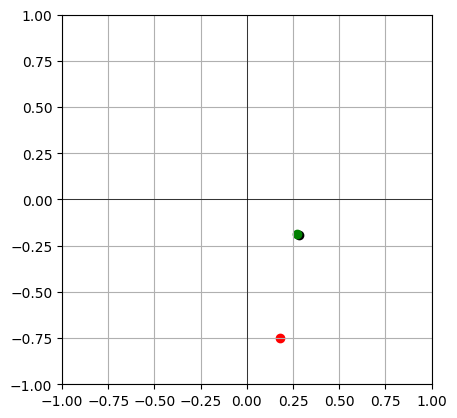

AttributeError: 'missile_interception' object has no attribute 'theta'

In [51]:
env = missile_interception()
env.reset()